In [1]:
#Import Dependencies needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Import the department of Labor and Department of Commerce Excel Sheets into separate dataframes. 

In [2]:
#Importing the data as a dataframe

df_labor = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Labor')

df_commerce = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Commerce')

In [ ]:
# Verify import worked, select one dataframe
df_labor

#### Select Department of Labor dataframe and generate counts for each value and plot in bar charts along with the count values.

In [ ]:
#Create an empty data frame
df_codebook = pd.DataFrame()

In [ ]:
#create list of columns you want the value counts for
columns=['Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52','Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89']

#loop through list and add counts to codebook
for column in columns:
    value = df_labor[column].value_counts()
    df_codebook[column] = value
    
df_codebook.head()

In [ ]:
#Plot the dataframe using a horizontal bar graph
df_transposed = df_codebook.T
df_transposed.plot(kind="barh", stacked=True)
plt.title("Value Counts of Questions with 1-5 Scale")
plt.xlabel("Value Counts")
plt.ylabel("Questions")
plt.legend(title="Answers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Recode any variables where this is necessary. 

In [ ]:
#Drop the columns that aren't necessary for the project as defined in the instructions

df_labor_relevant = df_labor[['RandomID', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q84', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL', 'DLEAVING']].copy()


### Deal With Missing Values
#### Identify and rows where a large number of responses are blank. Drop these rows.

In [ ]:
#which rows don't have many answers? take the average of the missing data and get the proportion missing
df_labor_relevant['row_missing_percent']=df_labor_relevant.isnull().mean(axis=1)
df_labor_relevant[df_labor_relevant['row_missing_percent']!=0.0]

In [ ]:
#plot histogram to check
df_labor_relevant['row_missing_percent'].hist()

In [ ]:
# drop rows with %missing more than 50% missing data
cutpoint = .5
#drop rows w
df_labor_relevant_answered = df_labor_relevant.loc[df_labor_relevant['row_missing_percent']<cutpoint]
df_labor_relevant_answered

In [ ]:
df_labor_relevant_answered.drop(labels='row_missing_percent', axis=1, inplace=True)

In [ ]:
#drop rows where the outcome variable is missing (this is what we are studying)
df_labor_relevant_answered = df_labor_relevant_answered.loc[df_labor_relevant_answered['DLEAVING'].isin(['A', 'B', 'C', 'D'])]
df_labor_relevant_answered

####   Check to see if any variables have blank/missing for more than 10% of their values. Decide whether you want to drop these variables. If you retain them consider running the models with and without those variables.

In [ ]:
#Check to see if any variables have blank/missing calculate percent missing for column
missing_df = pd.DataFrame(df_labor_relevant_answered.isnull().mean()).reset_index()
missing_df.rename({'index':'variable_name',0:'percent_missing'}, axis=1, inplace=True)
missing_df

#### For the variables with blank/missing or ‘Do Not Know’ values either recode those values to the median of the other values.

In [ ]:
# convert X to missing
df_labor_recoded = df_labor_relevant_answered.replace(r'X', np.nan, regex=True)
df_labor_recoded

In [ ]:
# put the columns in a list
df_labor_columns = df_labor_recoded.columns.tolist()
df_labor_columns

In [ ]:
#impute with mode (doesn't mess with distribution)
for impute_column in df_labor_columns:
    df_labor_recoded[impute_column].fillna(df_labor_recoded[impute_column].mode()[0], inplace=True)

In [ ]:
df_labor_recoded

#### Create a dummy variable for each row that captures whether any recodes were done. You will use this as an additional variable in your model.

#### For Question 84 you will need to create dummy codes. Plot the distribution of values and decide whether to create dummies for each value or whether to combine some. Describe why you made the choice you did.

In [ ]:
df_labor_recoded['Q84'].value_counts()

In [ ]:
#turn variable into a binary variable (do you have any unmet needs or is this org failing to meet your needs)
#Reducing it to either Needs are met 
df_labor_recoded['Q84'] = np.where(df_labor_recoded['Q84'].isin(['1', '2']),1,0)

In [ ]:
df_labor_recoded.info()

In [ ]:
#change type for numeric vars
numeric_vars = []
for num_columns in numeric_vars:
    df_labor_recoded[num_columns]=df_labor_recoded[num_columns].astype(int)
    
df_labor_recoded.info()

#### Recode the demographic variables using dummies

In [ ]:
#(6) get dummies for variables in Demographic Codes (DO NOT DO THIS FOR OUTCOME & Q84)
demo_dummies = pd.get_dummies(df_labor_recoded, columns=['DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL'])

demo_dummies.tail()

In [ ]:
demo_dummies.columns.to_list()

#### Recode the outcome variable so that 0 if ‘No’ (‘A’) or 1 if anything else ‘Yes’ (‘B’, ‘C’, ‘D’) 

In [ ]:
demo_dummies['DLEAVING'] = np.where(demo_dummies['DLEAVING'] == 'A', 0, 1)

demo_dummies

####  Combine all of the variables back into a single dataframe

In [ ]:
combined_labor_df = demo_dummies.copy()
combined_labor_df.info()

In [ ]:
combined_labor_df.columns.to_list()

#### Rename variables to be easier to interpret (suggest abbreviating or adding prefix or suffice to Q#)

## Correlation Matrix

#### Creat a correlation matric in the form of a heatmap.

In [ ]:

# Select the columns you need for Matrix
selected_columns = ['Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',]

# Create a new DataFrame with only the selected columns
corr_df = combined_labor_df[selected_columns].copy()
corr_df

In [ ]:

# Correlation between different variables (do not include Dummy Variables)
# Create a subset df specify the data we need 
corr = corr_df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(24, 20))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

#### Identify any variables that are correlated more than .8

In [ ]:
#Identify any variables that are correlated more than .8
#Export Correlation to a DF
corr = corr_df.corr()
corr_matrix_df = pd.DataFrame(corr)
corr_matrix_df


In [ ]:
# Loop over bottom diagonal of correlation matrix
for i in range(len(corr_matrix_df.columns)):
    for j in range(i):

        # Print variables with high correlation
        if abs(corr_matrix_df.iloc[i, j]) > 0.8:
            print(corr_matrix_df.columns[i], corr_matrix_df.columns[j], corr_matrix_df.iloc[i, j])



####    Either drop one (or more if several all highly correlated) or average them and create a new variable. For the variables that are grouped together in the codebook, it is more likely that they will highly correlate with each other. If this is the case, you can decide whether you want to take the average of those questions and just use the composite variable.

In [ ]:
#if you find a dataset that is strongly correlated you can collapse into a set by averaging

combined_labor_df['Q86_85']=(combined_labor_df['Q86']+combined_labor_df['Q85'])/2
combined_labor_df['Q60_55']=(combined_labor_df['Q60']+combined_labor_df['Q55'])/2
combined_labor_df['Q48_49_50_52']=(combined_labor_df['Q48']+combined_labor_df['Q49'])+(combined_labor_df['Q50']+combined_labor_df['Q52'])/4


In [ ]:
combined_labor_df.columns.to_list()

In [ ]:
reduced_labor_df_corr = combined_labor_df[[
 'Q86_85',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q56',
 'Q57',
 'Q59',
 'Q60_55',
 'Q46',
 'Q48_49_50_52']]

#### Once you have dropped and variables and/or created composites, create a new correlation matrix.

In [ ]:

# Correlation between different variables (do not include Dummy Variables)
# Create a subset df specify the data we need 
corr = reduced_labor_df_corr.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(24, 20))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

##### Split your data in training and test sets. When doing this remember to set the random seed to a number that you will keep constant.

In [ ]:
combined_labor_df.columns.to_list()

#### Step 1: Create the labels set (`y`)  from the “DLEAVING” column, and then create the features (`X`) DataFrame from the remaining columns.

In [ ]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = combined_labor_df['DLEAVING']

# Separate the X variable, the features
X = combined_labor_df.drop(columns=['DLEAVING', 'Q48', 'Q49', 'Q50','Q60', 'Q85', 'Q86','Q52','Q55','DRNO_D','DHISP_B', 'DDIS_B','DAGEGRP_B', 'DSUPER_B','DFEDTEN_C','DSEX_B','DMIL_B'])

In [ ]:
# Review the y variable Series
y[:5]

In [ ]:
# Review the X variable DataFrame
X.head()

#### Step 2: Check the balance of the labels variable (`y`) by using the `value_counts` function.

In [ ]:
# Check the balance of our target values
y.value_counts()

#### Step 3: Split the data into training and testing datasets by using `train_test_split`.

In [ ]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Logistic Regresssion


---
### Part 1

##### Create a Logistic Regression Model 

####  Run a logistic regression on the training data (`X_train` and `y_train`) setting the penalty parameter to ‘None’ in SKLearn.
---

In [ ]:
# Instantiate the Logistic Regression model
lr_classifier = LogisticRegression(penalty=None, solver='lbfgs', random_state=1)



In [ ]:
# Fit the model on the test data
lr_classifier.fit(X_train, y_train)

#### Save the predictions on the testing data labels by using the testing feature data (`X_test`) and the fitted model.

In [ ]:
# Make a prediction using the testing data
predictions = lr_classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

### Evaluate the model’s performance: Generate a confusion matrix.


In [ ]:
# Print the balanced_accuracy score of the model
# Display the accuracy score for the test dataset.
balanced_accuracy = accuracy_score(y_test, predictions)
print(balanced_accuracy)

In [ ]:
# Generate a confusion matrix for the model
lr_cm = confusion_matrix(y_test, predictions)
lr_cm_df = pd.DataFrame(
    lr_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(lr_cm_df)

In [ ]:
# Print the classification report for the model
print("Classification Report")
print(classification_report(y_test, predictions))

### Part 2


In [ ]:
# Run a second logistic regression model setting the penalty parament to 'l2'
# Instantiate the Logistic Regression model
lr_classifier2 = LogisticRegression(penalty='l2', solver='lbfgs', random_state=1)

In [ ]:
# Fit the model on the test data
lr_classifier2.fit(X_train, y_train)

In [ ]:
# Generate a confusion matrix for the model
lr_cm2 = confusion_matrix(y_test, predictions)
lr_cm_df2 = pd.DataFrame(
    lr_cm2, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(lr_cm_df2)

#### Random Forest

In [ ]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [ ]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [ ]:
 # Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
 # Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
rf_cm_df = pd.DataFrame(
    rf_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

### Compare best logistic regression model with random forest
----

### Visualize the Best Model


---

In [ ]:
shap.initjs()

In [ ]:
#Setting up SHAP Explainer
explainer = shap.Explainer(lr_classifier)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

# Test with data from other Commerce Dept
----

#### Select Department of Labor dataframe and generate counts for each value and plot in bar charts along with the count values.

## Recode any variables where this is necessary. 

In [3]:
#Drop the columns that aren't necessary for the project as defined in the instructions

df_commerce_relevant = df_commerce[['RandomID', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q84', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL', 'DLEAVING']].copy()


### Deal With Missing Values
#### Identify and rows where a large number of responses are blank. Drop these rows.

In [4]:
#which rows don't have many answers? take the average of the missing data and get the proportion missing
df_commerce_relevant['row_missing_percent']=df_commerce_relevant.isnull().mean(axis=1)
df_commerce_relevant[df_commerce_relevant['row_missing_percent']!=0.0]

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
0,171638000000,NaN,NaN,3.0,4.0,4.0,2.0,4.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387097
4,118318000000,NaN,5.0,4.0,4.0,5.0,3.0,4.0,4.0,4.0,...,B,B,B,B,B,C,A,B,A,0.032258
7,193837000000,3.0,4.0,4.0,3.0,3.0,4.0,4.0,5.0,5.0,...,NaN,NaN,NaN,NaN,A,NaN,NaN,B,NaN,0.225806
12,162473000000,5.0,4.0,3.0,4.0,5.0,5.0,4.0,5.0,4.0,...,B,B,NaN,B,A,B,NaN,B,B,0.064516
13,135041000000,3.0,4.0,2.0,3.0,4.0,3.0,3.0,4.0,NaN,...,B,B,B,B,A,B,A,A,C,0.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20985,182796000000,4.0,4.0,NaN,NaN,4.0,4.0,4.0,4.0,4.0,...,B,A,B,B,B,A,B,B,A,0.129032
20993,177891000000,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.838710
20995,143166000000,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.806452
20999,110575000000,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.0,4.0,...,C,B,B,A,A,A,A,B,A,0.161290


<Axes: >

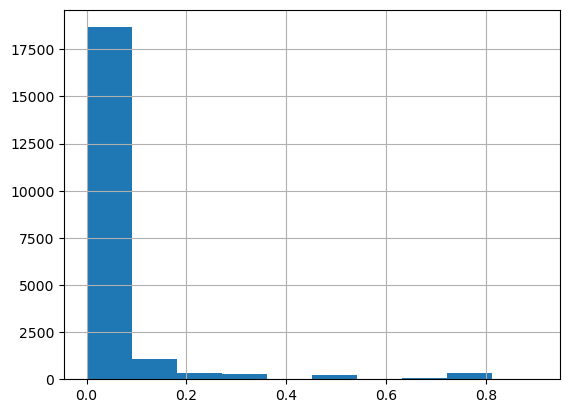

In [5]:
#plot histogram to check
df_commerce_relevant['row_missing_percent'].hist()

In [6]:
# drop rows with %missing more than 50% missing data
cutpoint = .5
#drop rows w
df_commerce_relevant_answered = df_commerce_relevant.loc[df_commerce_relevant['row_missing_percent']<cutpoint]
df_commerce_relevant_answered

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
0,171638000000,NaN,NaN,3.0,4.0,4.0,2.0,4.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387097
1,159842000000,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,...,B,B,B,B,A,B,A,A,B,0.000000
2,160709000000,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,B,B,B,B,B,C,A,B,A,0.000000
3,135627000000,2.0,2.0,2.0,4.0,3.0,2.0,3.0,3.0,2.0,...,B,B,A,B,A,C,B,B,A,0.000000
4,118318000000,NaN,5.0,4.0,4.0,5.0,3.0,4.0,4.0,4.0,...,B,B,B,B,B,C,A,B,A,0.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21003,147105000000,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,A,B,B,A,A,A,A,B,A,0.000000
21004,165175000000,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,3.0,...,B,B,B,B,A,A,A,B,B,0.000000
21005,197454000000,5.0,5.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,A,B,B,A,A,A,B,B,A,0.000000
21006,106631000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,C,B,B,A,A,A,B,B,A,0.000000


In [8]:
df_commerce_relevant_answered.drop(labels='row_missing_percent', axis=1, inplace=True)

KeyError: "['row_missing_percent'] not found in axis"

In [ ]:
#drop rows where the outcome variable is missing (this is what we are studying)
df_commerce_relevant_answered = df_commerce_relevant_answered.loc[df_commerce_relevant_answered['DLEAVING'].isin(['A', 'B', 'C', 'D'])]
df_commerce_relevant_answered

####   Check to see if any variables have blank/missing for more than 10% of their values. Decide whether you want to drop these variables. If you retain them consider running the models with and without those variables.

In [ ]:
# #Check to see if any variables have blank/missing calculate percent missing for column
# missing_df = pd.DataFrame(df_labor_relevant_answered.isnull().mean()).reset_index()
# missing_df.rename({'index':'variable_name',0:'percent_missing'}, axis=1, inplace=True)
# missing_df

#### For the variables with blank/missing or ‘Do Not Know’ values either recode those values to the median of the other values.

In [ ]:
# # convert X to missing
# df_labor_recoded = df_labor_relevant_answered.replace(r'X', np.nan, regex=True)
# df_labor_recoded

In [ ]:
# # put the columns in a list
# df_labor_columns = df_labor_recoded.columns.tolist()
# df_labor_columns

In [ ]:
# #impute with mode (doesn't mess with distribution)
# for impute_column in df_labor_columns:
#     df_labor_recoded[impute_column].fillna(df_labor_recoded[impute_column].mode()[0], inplace=True)

In [ ]:
# df_labor_recoded

#### Create a dummy variable for each row that captures whether any recodes were done. You will use this as an additional variable in your model.

#### For Question 84 you will need to create dummy codes. Plot the distribution of values and decide whether to create dummies for each value or whether to combine some. Describe why you made the choice you did.

In [ ]:
# df_labor_recoded['Q84'].value_counts()

In [ ]:
# #turn variable into a binary variable (do you have any unmet needs or is this org failing to meet your needs)
# #Reducing it to either Needs are met 
# df_labor_recoded['Q84'] = np.where(df_labor_recoded['Q84'].isin(['1', '2']),1,0)

In [ ]:
# df_labor_recoded.info()

In [ ]:
# #change type for numeric vars
# numeric_vars = []
# for num_columns in numeric_vars:
#     df_labor_recoded[num_columns]=df_labor_recoded[num_columns].astype(int)
    
# df_labor_recoded.info()

#### Recode the demographic variables using dummies

In [ ]:
# #(6) get dummies for variables in Demographic Codes (DO NOT DO THIS FOR OUTCOME & Q84)
# demo_dummies = pd.get_dummies(df_labor_recoded, columns=['DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL'])

# demo_dummies.tail()

In [ ]:
# demo_dummies.columns.to_list()

#### Recode the outcome variable so that 0 if ‘No’ (‘A’) or 1 if anything else ‘Yes’ (‘B’, ‘C’, ‘D’) 

In [ ]:
# demo_dummies['DLEAVING'] = np.where(demo_dummies['DLEAVING'] == 'A', 0, 1)

# demo_dummies

####  Combine all of the variables back into a single dataframe

In [ ]:
# combined_labor_df = demo_dummies.copy()
# combined_labor_df.info()

In [ ]:
# combined_labor_df.columns.to_list()

#### Rename variables to be easier to interpret (suggest abbreviating or adding prefix or suffice to Q#)

In [ ]:
#who does this predict poorly for
#how does it predict differently for 
#different sub-populations

#identify those it identifies correctly or incorrectly to 
#check for bias

#Key course parts for executing any project: Day 1 Supervised Learning: Activities 3 & 5; Day 2 Supervised Learning Activity 5; Day 2 Unsupervised Learning Activity 4